In [8]:
import torch
import torchvision
import os
import time
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [9]:
""" 数据读取 """
# 将图像数据转化为浮点数
batch_size = 256
resize = None
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.ToTensor()
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)

In [10]:
""" 定义网络结构 """
# 使用展平层进行输入的展平 将多维展成一维
# softmax 相当于全连接层 输入为 784 输出为 10
net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(784, 10))

# 初始化权重
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.1)
        # torch.nn.init.zeros_(m.bias)

net.apply(init_weights) # 每一层都运行这个函数

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [11]:
# 交叉熵损失函数
loss = torch.nn.CrossEntropyLoss(reduction='none') # 不进行降维操作(sum, mean)

In [12]:
# 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [13]:
""" 复用 DIY 里面的函数 """

""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

""" 评估 net 的准确性 """
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 如果是 torch 神经网络，则设置为评估模式，不进行反向传播
    accum = Accumulator(2)
    for X, y in data_iter:
        accum.add(accuracy(net(X), y), y.numel())
    return accum[0] / accum[1]

""" 一轮训练 """
def train_epoch_ch3(net, train_iter, loss, params, updater, lr):
    if isinstance(net, torch.nn.Module):
        net.train() # 训练模式，进行反向传播
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(params, lr, len(X)) # 更新器需要 batch_size
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

""" 训练函数 """
def train_ch3(net, train_iter, test_iter, loss, num_epochs, params, updater, lr):
    accumulator = [Accumulator(3) for _ in range(num_epochs)]
    for epoch in range(num_epochs):
        start = time.perf_counter()
        train_metrics = train_epoch_ch3(net, train_iter, loss, params, updater, lr) # 训练误差
        test_accuracy = evaluate_accuracy(net, test_iter) # 测试误差
        accumulator[epoch].add(train_metrics[0], train_metrics[1], test_accuracy)
        end = time.perf_counter()
        print(f"Finish {epoch + 1} train, cose {end-start:.3f} sec")
    return accumulator

In [14]:
""" 训练 """
num_epochs = 5
all_start = time.perf_counter()
accumulator = train_ch3(net, train_iter, test_iter, loss, num_epochs, None, trainer, None)
all_end = time.perf_counter()
print(f"\n Totally use {all_end-all_start:.3f} sec")

Finish 1 train, cose 10.020 sec
Finish 2 train, cose 10.501 sec
Finish 3 train, cose 10.179 sec
Finish 4 train, cose 9.868 sec
Finish 5 train, cose 9.407 sec

 Totally use 49.977 sec


Test accuracy : 0.824


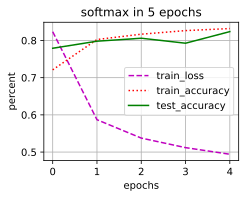

In [15]:
""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

""" 绘图 """
backend_inline.set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (3.5, 2.5)

train_loss, train_accuracy, test_accuracy = [], [], []
for i in range(num_epochs):
    train_loss.append(accumulator[i][0])
    train_accuracy.append(accumulator[i][1])
    test_accuracy.append(accumulator[i][2])
    
plt.plot(list(range(num_epochs)), train_loss, 'm--')
plt.plot(list(range(num_epochs)), train_accuracy, 'r:')
plt.plot(list(range(num_epochs)), test_accuracy, 'g-')
plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
plt.xlabel('epochs')
plt.ylabel('percent')
plt.title(f'softmax in {num_epochs} epochs')
plt.grid(True)

print(f"Test accuracy : {test_accuracy[-1]:.3f}")

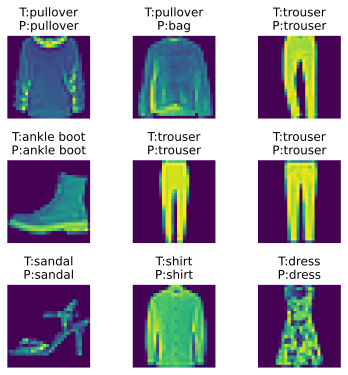

In [16]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


""" 预测值 """
def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    show_img(X[0:n].reshape([n, 28, 28]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 3)